<a href="https://colab.research.google.com/github/bnelson05/Probing/blob/main/Probing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model and Data

# Pick a Pretrained Model
For example, distilbert-base-uncased-finetuned-sst-2-english or textattack/bert-base-uncased-SST-2.

Make sure you set it so it returns hidden states (e.g., output_hidden_states=True in the config/forward pass).

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.2 MB/s eta 0:00:00


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

distil_model_name = "distilbert-base-uncased-finetuned-sst-2-english"
distil_tokenizer = AutoTokenizer.from_pretrained(distil_model_name)
distil_model = AutoModelForSequenceClassification.from_pretrained(distil_model_name)
distil_model.config.output_hidden_states = True
distil_model.eval()


bert_model_name = "textattack/bert-base-uncased-SST-2"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = AutoModelForSequenceClassification.from_pretrained(bert_model_name)
bert_model.config.output_hidden_states = True
bert_model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# Choose a Dataset
You can reuse an SST-2 dev/test split or a small subset of IMDB reviews—just keep it manageable (few hundred samples).

If you want to see domain differences, pick something that differs from the model’s training domain.

In [ ]:
from datasets import load_dataset

imdb_ds = load_dataset("imdb")
train_subset = imdb_ds["train"].shuffle(seed=42).select(range(300))
test_subset = imdb_ds["test"].shuffle(seed=42).select(range(300))

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

# Extract Hidden States

# Forward Pass
Tokenize each sentence, call model(**inputs), and ensure you’re receiving outputs.hidden_states.

# Layer Representation
For each sample, you’ll get a tuple of hidden states (like one for each layer).

Decide how to get a single vector for the sentence:

*   If it’s BERT, you can grab the [CLS] token’s embedding.
*   Or average the token embeddings if there’s no [CLS].

Save those embeddings (e.g., shape = [num_samples, hidden_dim]) for each layer, plus the true label.

In [ ]:
def get_hidden_states(model, subset, tokenizer):
  # ensures all layers including input embeddings are accounted for
  num_layers = model.config.num_hidden_layers + 1
  embeddings = [[] for _ in range(num_layers)]
  true_labels = []

  with torch.no_grad():
    for example in subset:
      sentence = example["text"]
      label = example["label"]

      # converts for model suitable input
      inputs = tokenizer(sentence, return_tensors="pt", truncation = True, max_length = 512)
      outputs = model(**inputs)
      hidden_states_received = outputs.hidden_states

      for i, layer in enumerate(hidden_states_received):
        # the CLS encodes information about the entire sentence
        # [batch, tokens, hidden_dim]
        cls = layer[0, 0, :].detach().cpu()
        embeddings[i].append(cls)

      true_labels.append(label)

  return embeddings, true_labels

# Training a Probe

# Logistic Regression
For each layer L, gather all embeddings into an (N, hidden_dim) array, with N = number of sentences.

Train a logistic regression (or SVM) to predict positive/negative.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class LogisticRegression(nn.Module):
  def __init__(self, input_dim):
    super(LogisticRegression, self).__init__()
    self.linear = nn.Linear(input_dim, 1)

  def forward(self, x):
    return self.linear(x).squeeze(-1)

def train_probe(hiddenStates, labels, model):
  layer_acc = {}
  trained_probes = {}
  num_layers = len(hiddenStates)

  for layer in range(num_layers):
    X_train = hiddenStates[layer]
    y_train = torch.tensor(labels, dtype = torch.float32)

    model = LogisticRegression(X_train.shape[1])
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(50):
      optimizer.zero_grad()
      outputs = model(X_train)
      loss = criterion(outputs, y_train)
      loss.backward()
      optimizer.step()

    with torch.no_grad():
      predictions = (torch.sigmoid(model(X_train)) > 0.5).float()
      accuracy = (predictions == y_train).float().mean().item()
      layer_acc[layer] = accuracy
      trained_probes[layer] = model

  return trained_probes

def evaluate_probe(trainedProbes, hiddenStates, labels, model, model_name):
  layer_acc = {}
  num_layers = len(hiddenStates)

  for layer in range(num_layers):
    X_test = hiddenStates[layer]
    y_test = torch.tensor(labels, dtype = torch.float32)

    model = trainedProbes[layer]

    with torch.no_grad():
      predictions = (torch.sigmoid(model(X_test)) > 0.5).float()
      accuracy = (predictions == y_test).float().mean().item()
      layer_acc[layer] = accuracy

    print(f"Test Layer {layer} -- Accuracy: {accuracy: .4f}")

  layers = list(layer_acc.keys())
  accuracies = list(layer_acc.values())

  plt.figure(figsize = (10, 5))
  plt.plot(layers, accuracies, marker = 'o', linestyle = '-', label = "Test Accuracy")
  plt.xlabel("Layer")
  plt.ylabel("Accuracy")
  plt.title(f"Layer-wise Sentiment Prediction Accuracy (Test Set) for {model_name}")
  plt.grid()
  plt.show()


Test Layer 0 -- Accuracy:  0.5000
Test Layer 1 -- Accuracy:  0.6333
Test Layer 2 -- Accuracy:  0.6867
Test Layer 3 -- Accuracy:  0.7267
Test Layer 4 -- Accuracy:  0.7433
Test Layer 5 -- Accuracy:  0.8467
Test Layer 6 -- Accuracy:  0.8767


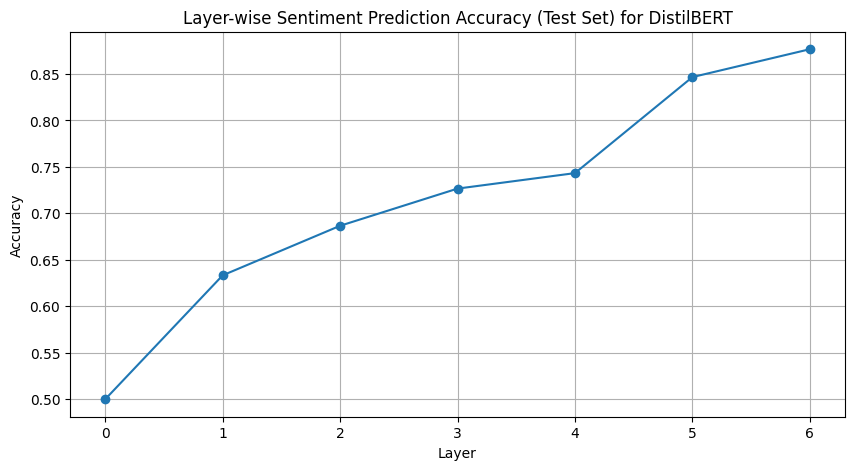

Test Layer 0 -- Accuracy:  0.5000
Test Layer 1 -- Accuracy:  0.5833
Test Layer 2 -- Accuracy:  0.6267
Test Layer 3 -- Accuracy:  0.6433
Test Layer 4 -- Accuracy:  0.6867
Test Layer 5 -- Accuracy:  0.6667
Test Layer 6 -- Accuracy:  0.6800
Test Layer 7 -- Accuracy:  0.7300
Test Layer 8 -- Accuracy:  0.7467
Test Layer 9 -- Accuracy:  0.8233
Test Layer 10 -- Accuracy:  0.8767
Test Layer 11 -- Accuracy:  0.8700
Test Layer 12 -- Accuracy:  0.8800


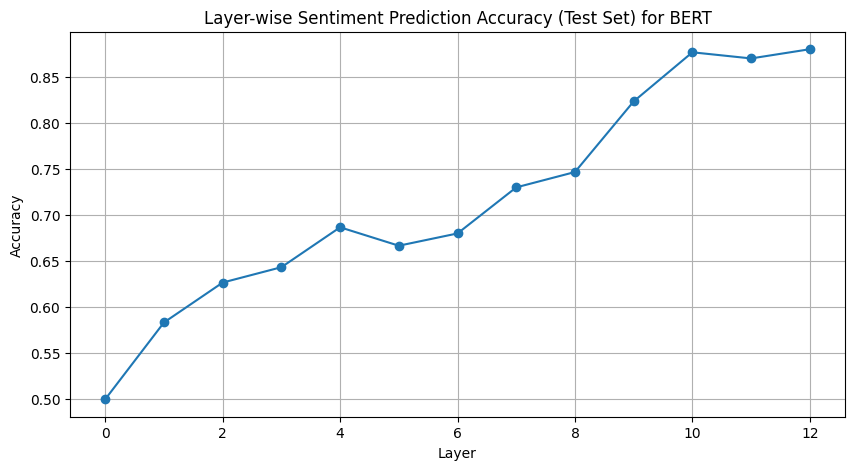

In [ ]:
distil_train_embeddings, distil_train_labels = get_hidden_states(distil_model, train_subset, distil_tokenizer)
distil_trainHiddenStates = [torch.stack(layer) for layer in distil_train_embeddings]
distil_trained_probes = train_probe(distil_trainHiddenStates, distil_train_labels, distil_model)

distil_test_embeddings, distil_test_labels = get_hidden_states(distil_model, test_subset, distil_tokenizer)
distil_testHiddenStates = [torch.stack(layer) for layer in distil_test_embeddings]
evaluate_probe(distil_trained_probes, distil_testHiddenStates, distil_test_labels, distil_model, "DistilBERT")



bert_train_embeddings, bert_train_labels = get_hidden_states(bert_model, train_subset, bert_tokenizer)
bert_trainHiddenStates = [torch.stack(layer) for layer in bert_train_embeddings]
bert_trained_probes = train_probe(bert_trainHiddenStates, bert_train_labels, bert_model)

bert_test_embeddings, bert_test_labels = get_hidden_states(bert_model, test_subset, bert_tokenizer)
bert_testHiddenStates = [torch.stack(layer) for layer in bert_test_embeddings]
evaluate_probe(bert_trained_probes, bert_testHiddenStates, bert_test_labels, bert_model, "BERT")

# Analysis & Write-Up

Overall, the final layer shows the highest accuracy (although the BERT model is between the 10th and final layer). If my 8th layer were to show strong attention to sentiment words in the 8th layer, I would also see higher accuracy for that layer. However, this doesn't necessarily indicate that this is the highest accuracy possible.

DistilBERT Model: Something that surprised me was how the accuracy changed at the 4th layer. I would think that a model's performance would steadily improve. This might be because the lower layers could be focusing on basic features of a sentence, such as syntax, while the higher layers could be focusing on the sentiment of words.

BERT Model: There was also an odd peak at the 4th layer, followed by a slight dip before increasing again. It started to increase more quickly at the 8th layer. Again, this might be because the lower layers are focusing on basic features of a sentence and layers like 4 and 8 are "transition" layers between what is being focused on.